<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/selectivity_and_tolerance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the FrequencyFreaks notebook. After working through this notebook you will be able to...
  * create gaussian, grating and gabor images
  * load an image and convert it to a grayscale image and interpolate to the size that you want
  * take the 2D discrete Fourier Transform of an image
  * examine components of the Fourier Transform to confirm the way in which orientation and spatial frequency is laid out
  * create a gaussian filter in the Fourier Domain and apply it to an image
  * low-pass or high-pass filter an image
  * apply an oriented band-pass filter to an image by using the convolution theorem to multiply the fourier transform of an appropriate gabor
  * demonstrate that a difference-of-gaussians receptive field will have a difference-of-gaussian contrast sensitivity function as derived in the Enroth-Cugell paper

In [58]:
# Import libraries that we need
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import imageio as iio
from scipy import interpolate

Let's start by defining a few functions from the [frequency freaks](https://colab.research.google.com/drive/1Yxj-Cld8uV3uNQ28WNcgH0udZVqJbdgy) notebook. We will need these to create gabor receptive fields.

In [132]:
# function to make a mesh of x,y points
def getMeshPoints(nPoints):

  # first create a linearly spaced set of x and y points between -1 and 1
  x = np.linspace(-1,1,nPoints)
  y = np.linspace(-1,1,nPoints)

  # keep the extents for use with imshow
  extents = [np.min(x),np.max(x),np.min(y),np.max(y)]

  # now create the mesh of x and y (these will now both be 2D matrices of x and y values)
  x, y = np.meshgrid(x, y, indexing='xy')

  # and return the computed values
  return x, y, extents

# function that makes a gaussian
def makeGaussian(x,y,sigma):
  # there it is!
  gaussian = np.exp(-(x**2+y**2)/(2*sigma**2))
  
  # return 
  return gaussian

# function to make a grating
def makeGrating(x, y, orientation, spatialPhase, spatialFrequency):
  # we wil convert orientation and spatialPhase into radians
  orientation = np.pi*orientation/180
  spatialPhase = np.pi*spatialPhase/180

  # we need to convert spatial frequency into cycles/image
  # remember that we made the extents in getMeshPoints
  # to go from -1 to 1, so we want that to go from -pi to pi
  spatialFrequency = spatialFrequency * np.pi

  # make the grating
  grating = np.cos(spatialFrequency*(x*np.cos(orientation)+y*np.sin(orientation))+spatialPhase)

  # and return
  return grating

Now that we have those functions, lets make a class variable that will contain the necessary things to represent a simple cell - the linear receptive field and the exponent. In fact, let's make it create a gabor receptive field with a particular spatial frequency, orientation and keep a field that tells what the static output non-linearity is. You know from the [FrequencyFreak](https://colab.research.google.com/drive/1Yxj-Cld8uV3uNQ28WNcgH0udZVqJbdgy)s notebook how to do this from the above functions. Yes?

In [133]:
class simpleCell:
  def __init__(self,meshsize, orientationPreference, spatialPhase, spatialFrequencyPreference, exponent):
    # keep the meshsize
    self.meshsize = meshsize
    
    # first make a mesh of x,y points
    self.x, self.y, self.extents = getMeshPoints(meshsize)

    # compute the grating needed
    grating = makeGrating(self.x, self.y, orientationPreference, spatialPhase, spatialFrequencyPreference)

    # compute the gaussian (we fix the size here, but of course that could be a passed
    # in parameter)
    gaussian = makeGaussian(self.x, self.y, 0.2)

    # now we can make the gabor receptive field
    self.linearRF = grating * gaussian

    # the exponent is just something we store
    self.exponent = exponent

Let's test it to see if generates what we want it to, by creating a simpleCell and displaying it's receptive field.

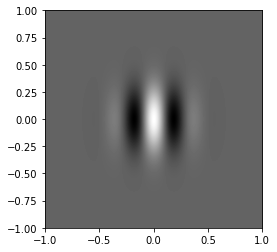

In [134]:
# let's use the following gridsize in all these simulations
gridsize = 513

# create the simple cell
s = simpleCell(gridsize, 0, 0, 5, 2)

# display the receptive field
plt.imshow(s.linearRF,cmap='gray',extent=s1.extents)

Ok, your turn. Create a quadrature pair of simple cells like we discussed in class. Call them s1 and s2 and display their receptive fields to make sure they look right. Use a vertical orientation (orientationPrefernce = 0) just to make the rest of this notebook a bit easier and let's keep the spatial frequency as above.

Now, let's write a function that will compute the simple cell response to some a stimulus image. 

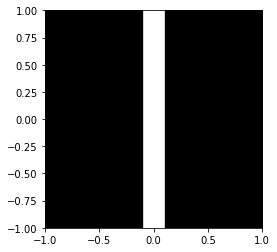

In [136]:
# first let's generate a stimulus image where 1 = white, 0 = gray -1 = black
stimImage = np.zeros((gridsize,gridsize))

# let's make it have a white vertical bar in it
stimImage[np.nonzero(np.logical_and(s.x > -0.1, s.x < 0.1))] = 1

# and display to make sure we have the right thing
plt.imshow(stimImage,cmap='gray',extent=s.extents)

# ok, now we have a stimulus, let's write a function to compute the simple cell response
def computeSimpleCellResponse(simpleCell, stimulus):
  # well, the first step is to apply the linear receptive field
  # which means to take the dot product of the linear receptive field
  # and the stimulus. Note, I don't understand what numpy's dot product
  # does in 2D - so maybe there is a better way to write this. Instead
  # I'm going to go really basic here. Take the element-wise multiplication
  # of stimulus and RF and then add that all up together
  response = simpleCell.linearRF * stimulus
  response = np.sum(response)

  # since the units of the output are aribtrary, let's
  # make them a bit more intepretable where 1 would be the
  # maximum possible reponse of the RF with it's most preferred
  # stimulus. What is the most preferred stimulus, well the one
  # that exactly matches the RF!
  maxResponse = simpleCell.linearRF * simpleCell.linearRF
  maxResponse = np.sum(maxResponse)

  # now normalize by this maximum response
  response = response / maxResponse

  # now we apply a threshold
  if response<0:
    response = 0
  
  # and apply the static non-linearity
  response = response**simpleCell.exponent
  
 # and return, couldn't be simpler, no pun intended. really.
  return response

# with that function defined, let's get the response to our stimulus
r = computeSimpleCellResponse(s, stimImage)

Got it? Ok. Let's plot a tuning function. In this case, let's plot the tuning of the RF with respect to the position of the bar

Text(0, 0.5, 'Response')

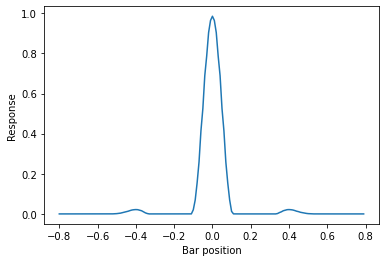

In [115]:
# create a function to compute the response to a vertical
# bar at different locations in the receptive field
def computeResponseToVerticalBar(simpleCell, barLuminance):

  # init response array
  r = []

  # bar positions to examine simple cell response over
  barPositions = np.arange(-0.8, 0.8, 0.01) 

  # specify the size of the bar
  halfBarWidth = 0.1

  # now for each bar position, compute the simple cell response
  for barLoc in barPositions:
    # let's make it have a white vertical bar in it at the barLoc
    stimImage = np.zeros((gridsize,gridsize))
    stimImage[np.nonzero(np.logical_and(s.x > barLoc-halfBarWidth, s.x < barLoc+halfBarWidth))] = barLuminance

    # compute response
    r.append(computeSimpleCellResponse(simpleCell, stimImage))

  # return values
  return barPositions, np.array(r)

# now compute the response for the receptive field we created above
# we set the barLuminance to 1 to do a bright bar
barPositions, r = computeResponseToVerticalBar(s,1)

# plot the response
plt.plot(barPositions,r)
plt.xlabel('Bar position')
plt.ylabel('Response')

Ok, now we can compute the response of a single simple cell for different bar positions. Note that the response is not uniform across the receptive field - i.e. the simple cell only responds to the bar at a position it which it aligns with the excitatory or on part of the receptive field. What happens, if we put on a dark bar at different positions across the receptive field. What would it look like?

Text(0, 0.5, 'Response')

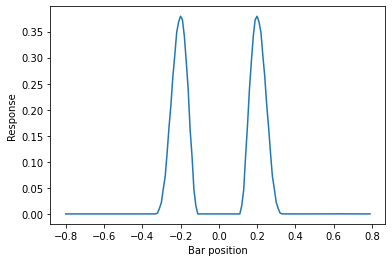

In [137]:
# compute the response to a dark bar
barPositions, r = computeResponseToVerticalBar(s,-1)

# plot the response
plt.plot(barPositions,r)
plt.xlabel('Bar position')
plt.ylabel('Response')

Is that what you expected? I hope so. Now, let's try to make a cell (complex cell) that will respond to a bar with a positive response across the whole receptive fields. Ok, one point we have to take care of. We didn't talk about this in class, but note that the simple cell we have made applies "half-squaring" to the output. That means it thresholds at 0 and sets any negative values to 0 and then squares. The upshot of this is that  the cell can not respond negatively. This is actually fairly accurate as cortical cells (as opposed to retinal ganglion cells typically have low baseline firing. That means, that they have very little negative range - they cant suppress their baseline firing rate below 0 (after all it makes no sense to say that a neuron is firing less than 0 spikes/sec, right?). So if it's baseline is near 0, then it only signals positive responses, and nothing about negative responses. Look at the graphs above and confirm that this is true. So, how do we fix this? Simple. We just have two simple cells that have tuning that is 180 degrees out of phase with each other. One simple cell gives the positive response and one simple cell gives the negative response - i.e. responds in the dark regions of the other cell. By combining those cells we get a combined response that responds to postivie and negative luminance. Here's some code that implements that idea.

Text(0, 0.5, 'Response')

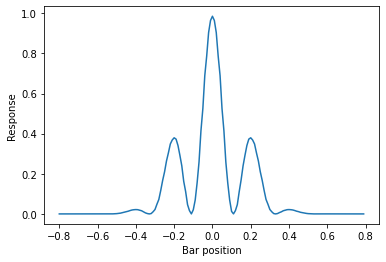

In [152]:
# create a simple cell
s1positive = simpleCell(gridsize,0,0,5,2)

# now create one with the opposite phase (i.e. 180 degrees out of phase)
s1negative = simpleCell(gridsize,0,180,5,2)

# now compute the response of both to bar above
barPosition, s1positiveResponse = computeResponseToVerticalBar(s1positive,1)
barPosition, s1negativeResponse = computeResponseToVerticalBar(s1negative,1)

# ok, add them in opponency
s1response = s1positiveResponse + s1negativeResponse

# and plot
plt.plot(barPosition,s1response)
plt.xlabel('Bar position')
plt.ylabel('Response')

Ok, half way there. We have one half of the quadrature phase. Now you do the rest. Compute a response that is in quadrature phase and add it to what you have here. Then you should have a complex cell that responds positively throughout the receptive field.

Text(0, 0.5, 'Response')

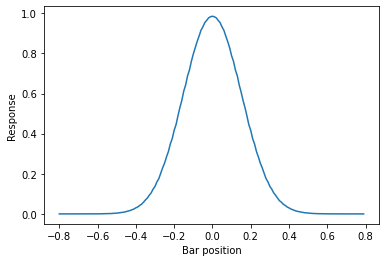

In [153]:
# create a simple cell
s2positive = simpleCell(gridsize,0,90,5,2)

# now create one with the opposite phase (i.e. 180 degrees out of phase)
s2negative = simpleCell(gridsize,0,270,5,2)

# make a function to compute 
barPosition, s1positiveResponse = computeResponseToVerticalBar(s1positive,1)
barPosition, s1negativeResponse = computeResponseToVerticalBar(s1negative,1)
barPosition, s2positiveResponse = computeResponseToVerticalBar(s2positive,1)
barPosition, s2negativeResponse = computeResponseToVerticalBar(s2negative,1)

# add them together and you should get a complex cell
complexResponse = (s1positiveResponse+s1negativeResponse) + (s2positiveResponse+s2negativeResponse)

# and plot
plt.plot(barPosition,complexResponse)
plt.xlabel('Bar position')
plt.ylabel('Response')